This is the same as before, setting up data first. With slight alterations for transfer learning.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

images_path = os.getcwd()
print(images_path)

def refresh_dir(path, name):
    try:
        shutil.rmtree(path + name)
    except Exception as e:
        print("Couldn't remove " + str(path) + str(name))
    finally:
        os.mkdir(path + name)

refresh_directories = ["/Images-Using/Other-Usable"]
for ref_dir in refresh_directories:
    refresh_dir(images_path, ref_dir)
    
def do_splits(src, directory_given, class_idx):
    directory = images_path + directory_given
    allFileNames = os.listdir(directory)
    allFileNames = [src + directory_given + '/' + name for name in allFileNames]
    directory = "/Images-Using/Other-Usable"

    idx = 0
    for name in allFileNames:
        failed_naming = True
        while failed_naming:
            try:
                shutil.copy(name, src + directory)
                os.rename(src + directory + '/' + name.rsplit('/', 1)[-1],
                          src + directory + '/' + str(class_idx) + '-' + str(idx) + name.rsplit('/', 1)[-1])
                failed_naming = False
            except:
                idx += 1
            idx += 1

classes = ["/Human", "/Nature-Background", "/Text", "/Dogs", "/Cats", "/Hamsters", "/Suggestively-Sexual",
           "/Suggestively-Violent", "/Abstract-Background", "/Empty-Cages", "/Bunny-Drawings"]
class_idx = 0
for class_dir in classes:
    do_splits(images_path, "/Other-Directory" + class_dir, class_idx)
    class_idx += 1

batch_size = 32
img_height = 160
img_width = 160

split_directory = images_path + "/Images-Using"

train_ds = tf.keras.utils.image_dataset_from_directory(
    split_directory,
    validation_split=0.2,
    subset="training",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    split_directory,
    validation_split=0.2,
    subset="validation",
    seed=321,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

/Users/Alex/Desktop/Image-Classification
Found 1222 files belonging to 2 classes.
Using 978 files for training.
Metal device set to: Apple M1 Pro
Found 1222 files belonging to 2 classes.
Using 244 files for validation.


2022-10-08 15:01:59.230603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-08 15:01:59.230794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


This time we'll have 25% of the validation set become the testing set.

In [2]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 4)
validation_ds = validation_ds.skip(val_batches // 4)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 6
Number of test batches: 2


As explained in the previous example, this code makes our dataset more efficient for testing.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

This is a new concept! We want to generalize our model, and a way of doing that is to slighly augment incoming images into the model that are trained multiple times on. We slightly rotate and flip images for this better generalization.

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Now we'll import mobilenetV2, one of the best CNNs available that comes pretrained on millions of images. This CNN can already act as the eyes of our network and recognize complex patterns needed in CV.

In [5]:
IMG_SIZE = (160, 160)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Now what we have at the end of the architecture is a 5x5 1280 element vector. This isn't that useful, and is hard to interpret without averaging the results into a single 1280 element vector.

Before we do this we take a batch of images from the training dataset (both the images themselves and the labels associated with them) and feed in what the images will look like and how many (this is the feature batch). We do this seemingly unrelated action now because we need to have our feature_batch_average pooling know how many images are per batch.

Lastly we just set the model to non-trainable because we don't want to waste time with a massive CNN training on a few examples that at best, barely help the process and at worst, deteriorate the CNN's abililty to make meaningful distinctions in data by biasing the model.

In [6]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

base_model.trainable = False

2022-10-08 15:02:24.805740: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Now we add a prediction layer to turn our 32x1x1280 vectors into 32x1x1 scalar predictions of "Bunny" or "No Bunny".

In [7]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


This code puts all the pieces together.
1. We set our input shape to the required 160x160.
2. We preprocess the data from [0,255] scalar values to [-1,1] float values.
3. We add our base model, and specify again that we aren't training the base model.
4. Add our averaging layer.
5. We add a dropout layer for the purposes of avoiding overfitting and better generalization.
6. We finally add our prediction layer to get a "Bunny" or "No Bunny" label of 0 or 1.
7. We neatly wrap this up into a keras model architecture.
8. We set a learning rate for our model.
9. Compile the model.
10. Print out the final architecture.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Now we do some standard training of the model. We run for 20 epochs here for obvious reasons shown below.

In [9]:
initial_epochs = 20

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/20


2022-10-08 15:02:36.199200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.5869

2022-10-08 15:02:42.624231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 8s 209ms/step - loss: 0.7408 - accuracy: 0.5869 - val_loss: 0.6026 - val_accuracy: 0.6611
Epoch 2/20
31/31 [==============================] - 6s 183ms/step - loss: 0.6450 - accuracy: 0.6329 - val_loss: 0.5882 - val_accuracy: 0.6222
Epoch 3/20
31/31 [==============================] - 6s 181ms/step - loss: 0.5885 - accuracy: 0.6861 - val_loss: 0.5166 - val_accuracy: 0.6778
Epoch 4/20
31/31 [==============================] - 6s 180ms/step - loss: 0.5561 - accuracy: 0.7055 - val_loss: 0.4667 - val_accuracy: 0.7389
Epoch 5/20
31/31 [==============================] - 6s 179ms/step - loss: 0.5073 - accuracy: 0.7413 - val_loss: 0.4478 - val_accuracy: 0.7278
Epoch 6/20
31/31 [==============================] - 6s 179ms/step - loss: 0.4462 - accuracy: 0.7883 - val_loss: 0.4191 - val_accuracy: 0.7722
Epoch 7/20
31/31 [==============================] - 6s 181ms/step - loss: 0.4271 - accuracy: 0.7986 - val_loss: 0.4045 - val_accuracy: 0.7667
Epoch 8/20
31/31 

Now we show the results! As we can see the training and validation go along side by side with some fears of overfitting. But as our test data shows below we don't actually overfit that much (Or so we think! Our test dataset isn't the biggest and may be slightly off).

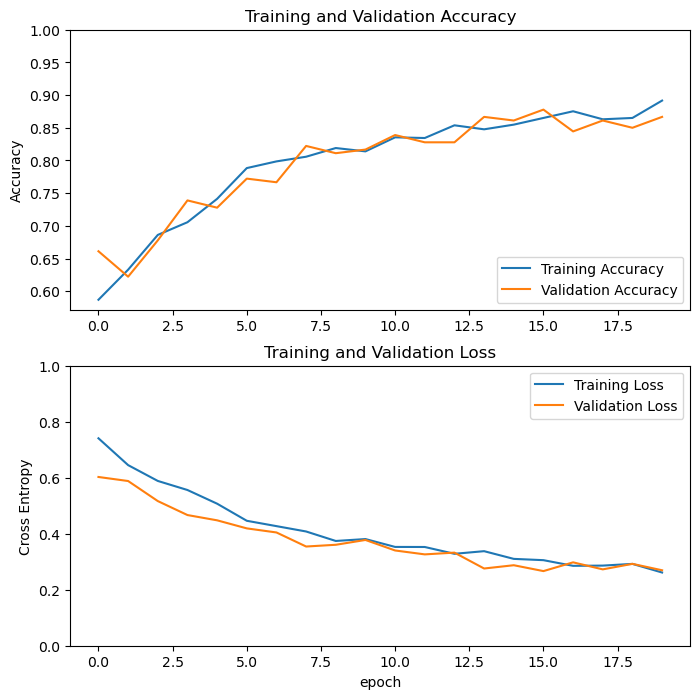

2/2 [==============================] - 0s 32ms/step - loss: 0.3076 - accuracy: 0.8438


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(test_ds)

This last bit is just for fun! We can look at what labels our model gives!

Predictions:
 [1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1]
Labels:
 [1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1]


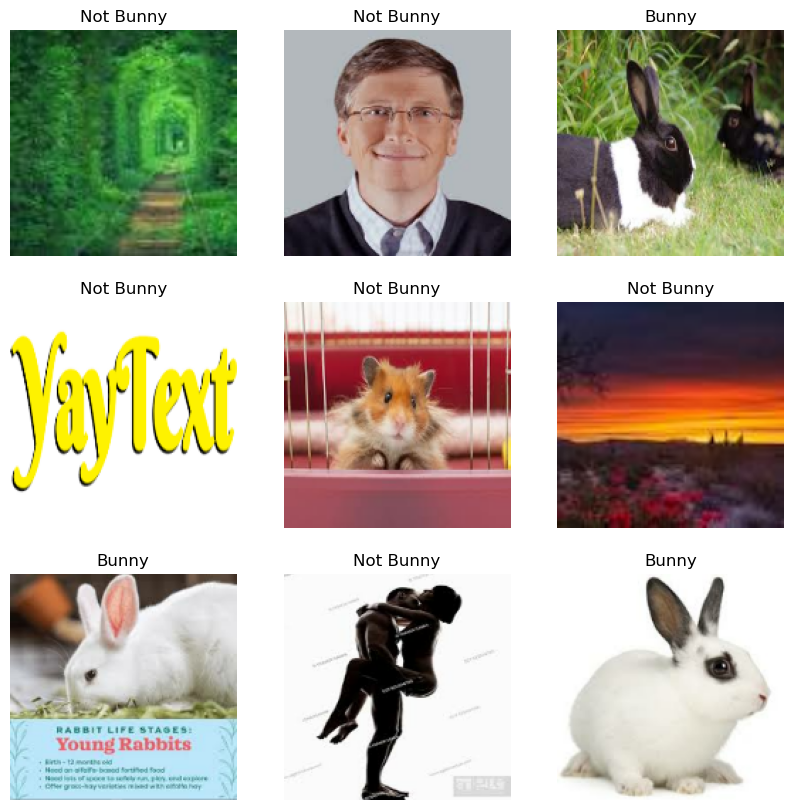

In [13]:
class_names = ["Bunny", "Not Bunny"]

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")